In [25]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
df = pd.read_csv("./data/fake_news_data.csv")

In [27]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [28]:
unique_domains = list(df["source_domain"].unique())
unique_titles = list(df["title"].unique())

In [29]:
num_words=10000
num_domains = len(unique_domains)

In [30]:

title_input = keras.Input(shape=(1,), name="title", dtype=tf.string)
source_domain_input = keras.Input(shape=(1,), name="domain", dtype=tf.string)

tweet_num_input = keras.Input(shape=(1,), dtype="int32", name="tweet_num")

title_vectorizer = keras.layers.TextVectorization(max_tokens=num_words)
title_vectorizer.adapt(unique_titles)

title_vector = title_vectorizer(title_input)

source_domain_lookup = keras.layers.StringLookup(vocabulary=unique_domains)(source_domain_input)

In [31]:
title_features=layers.Embedding(num_words+1, 64)(title_vector)
source_domain_embedding = layers.Embedding(num_domains+1, 64)(source_domain_lookup)
tweet_num_normalized = layers.Normalization()
tweet_num_normalized.adapt(df["tweet_num"])

In [32]:
title_features = layers.LSTM(128)(title_features)
source_domain_features = layers.GlobalAveragePooling1D()(source_domain_embedding)

In [33]:
x = layers.concatenate([title_features, source_domain_features])

In [34]:
is_real_pred = layers.Dense(1, name="real", activation="sigmoid")(x)

In [35]:
model = keras.Model(inputs=[title_input, source_domain_input], outputs=[is_real_pred])

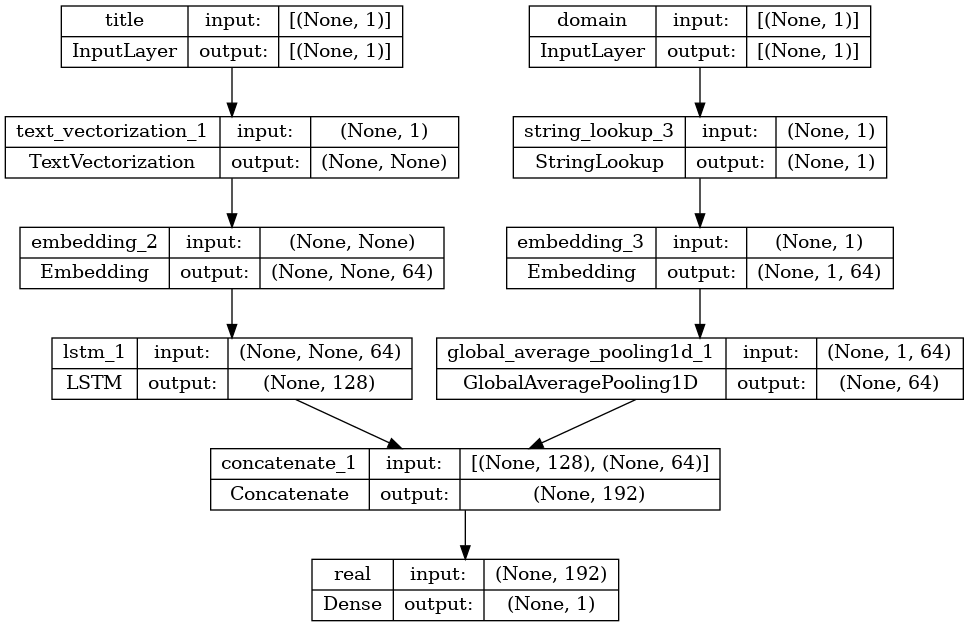

In [36]:
keras.utils.plot_model(model, show_shapes=True)

In [37]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["binary_accuracy"]
)

In [38]:
import numpy as np

In [39]:
title_data = np.array((df["title"].astype(str)))
domain_data = np.array(df["source_domain"].astype(str))

target = np.array(df["real"].astype(int))

In [40]:
history = model.fit({"title":title_data, 
            "domain":domain_data},
            {"real":target}, 
            epochs=15)

Epoch 1/15
725/725 [==============================] - 45s 56ms/step - loss: 0.3895 - binary_accuracy: 0.8409
Epoch 2/15
725/725 [==============================] - 39s 54ms/step - loss: 0.3093 - binary_accuracy: 0.8778
Epoch 3/15
725/725 [==============================] - 40s 55ms/step - loss: 0.2890 - binary_accuracy: 0.8868
Epoch 4/15
725/725 [==============================] - 40s 56ms/step - loss: 0.2769 - binary_accuracy: 0.8893
Epoch 5/15
725/725 [==============================] - 39s 54ms/step - loss: 0.2673 - binary_accuracy: 0.8954
Epoch 6/15
725/725 [==============================] - 41s 57ms/step - loss: 0.2572 - binary_accuracy: 0.8986
Epoch 7/15
725/725 [==============================] - 40s 55ms/step - loss: 0.2459 - binary_accuracy: 0.9047
Epoch 8/15
725/725 [==============================] - 41s 56ms/step - loss: 0.2363 - binary_accuracy: 0.9093
Epoch 9/15
725/725 [==============================] - 42s 58ms/step - loss: 0.2258 - binary_accuracy: 0.9150
Epoch 10/15
725/725

In [48]:
df_samples = df.sample(n=10)
sample_titles = np.array(df_samples["title"])
sample_domains = np.array(df_samples["source_domain"])

In [49]:
input_example = {
    "title":sample_titles,
    "domain":sample_domains
}

In [50]:
predictions = model.predict(input_example)

1/1 [==============================] - 1s 1s/step


In [54]:
print("Predictions", ["real" if pred >= .5 else "fake" for pred in predictions])
print("Actual", ["real" if target == 1 else "fake" for target in df_samples["real"]])


Predictions ['real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real']
Actual ['real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real']
